In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pylab as pl
import sklearn.decomposition as deco
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# simulate positive and negative samples with noise rate around 6/66=9.1%
def simulateSamples(num_samples, sample_date, time_start, time_end, sample_label, src_ip_samples):

    # generate a sample of random source IPs from a set of IPs
    rand_src_ips = np.random.choice(src_ip_samples, num_samples)

    # generate a sample of random destination IPs from a set of IPs
    dest_ip_samples = ['0.0.0.0', '0.0.0.1', '0.0.0.2', '0.0.0.3', '0.0.0.4', 
                       '0.0.0.5', '0.0.0.6', '0.0.0.7', '0.0.0.8', '0.0.0.9']
    rand_dest_ips = np.random.choice(dest_ip_samples, num_samples)

    # generate a sample of visits given a range, following uniform distribution
    visits_samples = np.random.randint(200, 500, num_samples)

    # generate a sample of time, following uniform distribution
    timeofday_samples = np.random.uniform(time_start, time_end, num_samples)

    # generate a list of dates and alert labels
    date_samples = np.random.choice([sample_date], num_samples)
    false_alerts = np.random.choice([sample_label], num_samples)


    data_df = pd.DataFrame()
    data_df['srcIP'] = rand_src_ips
    data_df['destIP'] = rand_dest_ips
    data_df['visits'] = visits_samples
    data_df['timeofday'] = timeofday_samples
    data_df['date'] = date_samples
    data_df['falsealert'] = false_alerts

    return data_df

all_data = pd.DataFrame()
# a set of IPs creating real attacks and alerts
ips1 = ['1.1.1.0', '1.1.1.1', '1.1.1.2', '1.1.1.3', '1.1.1.4',                       
        '1.1.1.5', '1.1.1.6', '1.1.1.7', '1.1.1.8', '1.1.1.9']
# a set of IPs creating false attacks and alerts
ips2 = ['2.2.2.0', '2.2.2.1', '2.2.2.2', '2.2.2.3', '2.2.2.4']

for cdate in pd.date_range('1/1/2017', '1/20/2017'):
    # simulate true alerts
    all_data = all_data.append(simulateSamples(50, cdate, 0.0, 24.0, 0, ips1))
    # add some noise
    all_data = all_data.append(simulateSamples(5, cdate, 0.0, 24.0, 1, ips1))
    # simuate false alerts
    all_data = all_data.append(simulateSamples(10, cdate, 18.0, 19.0, 1, ips2))
    # add some noise
    all_data = all_data.append(simulateSamples(1, cdate, 18.0, 19.0, 0, ips2))

# save to file
all_data.to_csv('simulated_data.csv', 
                columns=['srcIP', 'destIP', 'visits', 'timeofday', 'date', 'falsealert'],
                index=False)

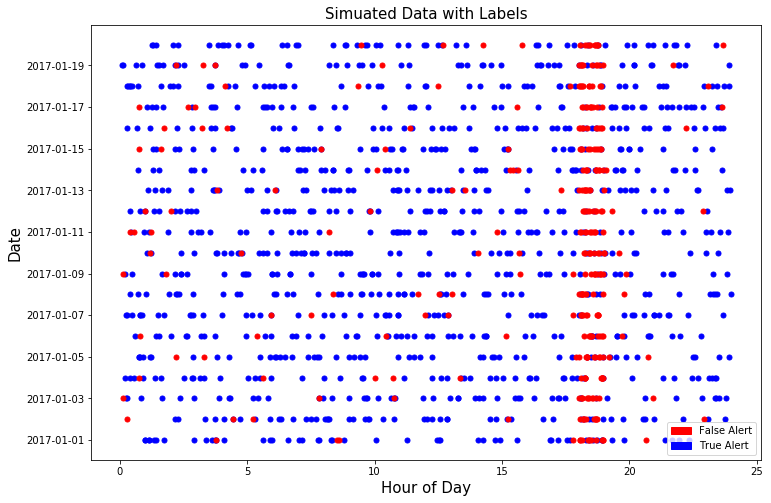

In [12]:
# let's visualize our simulated data to make sure that it makes sense as our expections
plt.figure(figsize=[12, 8])
ax = plt.plot(all_data['timeofday'][(all_data['falsealert'] == 0)], 
              all_data['date'][(all_data['falsealert'] == 0)], 'bo', markersize=5)
ax = plt.plot(all_data['timeofday'][(all_data['falsealert'] == 1)], 
              all_data['date'][(all_data['falsealert'] == 1)], 'ro', markersize=5)
red_patch = mpatches.Patch(color='red', label='False Alert')
blue_patch = mpatches.Patch(color='blue', label='True Alert')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Date', fontsize=15)
plt.title('Simuated Data with Labels', fontsize=15)
plt.show()
plt.close()

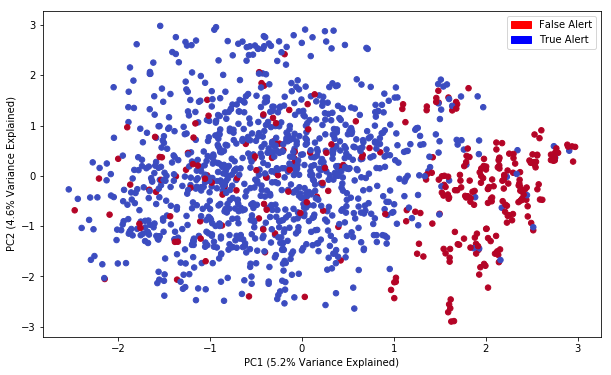

In [4]:
train = pd.read_csv("simulated_data.csv", parse_dates=['date'])
# convert categorical variables to dummy binary variables
# you know random forest could not handle categorical values
train = pd.get_dummies(train, columns = ['srcIP', 'destIP'])

x = train.copy()
x = x.drop(['date', 'falsealert'], axis=1)
# You need to normalize your data first before PCA
x = (x - np.mean(x, 0)) / np.std(x, 0)
# 2D PCA
pca = deco.PCA(2)
# transform the data into first two components
x_r = pca.fit(x).transform(x)
# print pca.explained_variance_ratio_
plt.figure(figsize=[10, 6])
ax = plt.scatter(x_r[:, 0], x_r[:, 1], c=train['falsealert'].values, cmap='coolwarm', s=30)
red_patch = mpatches.Patch(color='red', label='False Alert')
blue_patch = mpatches.Patch(color='blue', label='True Alert')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('PC1 (5.2% Variance Explained)')
plt.ylabel('PC2 (4.6% Variance Explained)')
plt.show()

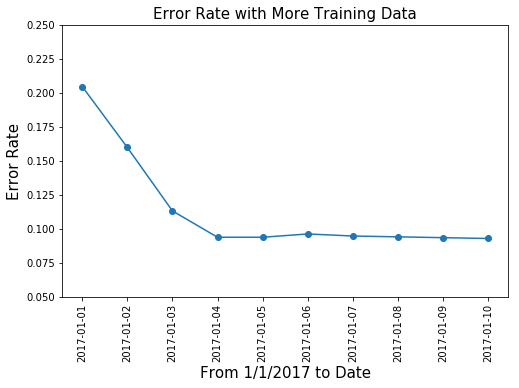

In [13]:
# prepare training data
cols = train.columns.drop(['date', 'falsealert'])
colsRes = ['falsealert']

def trainAndTest(end_date):
    train_dates = ((train['date'] >= '1/1/2017') & (train['date'] <= end_date))
    trainArr = train[train_dates].as_matrix(cols)    # training array
    trainRes = train[train_dates].as_matrix(colsRes).ravel() # training results

    ## Training!
    # this is a good number based on our samples and features
    rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=3)
    # finally, we fit the data to the algorithm!!! :)
    rf.fit(trainArr, trainRes)

    num_errors = 0
    # test on another 10 days of data
    for cdate in pd.date_range('1/11/2017', '1/20/2017'):
        testArr = train[train['date'] == cdate].as_matrix(cols)    # training array
        testRes = train[train['date'] == cdate].as_matrix(colsRes).ravel() # training results
        results = rf.predict(testArr)
        num_errors += sum(abs(results - testRes))
    return num_errors

error_df = pd.DataFrame()
# train on gradually more and more data
# test on another independent 10 days of data
for cdate in pd.date_range('1/1/2017', '1/10/2017'):
    error_sum = 0
    for i in [1,2,3,4,5]:
        error_sum += trainAndTest(cdate)
    error_rate = error_sum / 5.0 / 660.0
    error_df = error_df.append(pd.DataFrame([[cdate, error_rate]], columns=['Date', 'Error Rate']))
plt.figure(figsize=[8, 5])
plt.plot(error_df['Date'], error_df['Error Rate'], marker='o')
plt.ylim([0.05, 0.25])
plt.title('Error Rate with More Training Data', fontsize=15)
plt.xlabel('From 1/1/2017 to Date', fontsize=15)
plt.ylabel('Error Rate', fontsize=15)
plt.xticks(rotation=90)
plt.show()
plt.close()

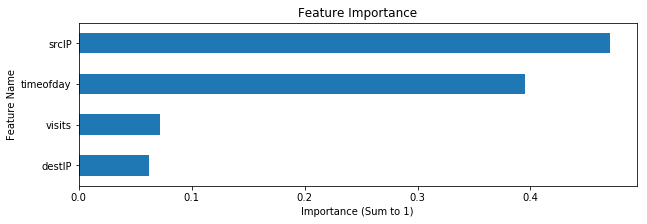

In [7]:
## let's visualized the feature importance
## as expected the most important features are srcIP and timeofday
## visits and destIP are pure random between 'True Alerts' and 'False Alerts'
train_dates = ((train['date'] >= '1/1/2017') & (train['date'] <= '1/10/2017'))
trainArr = train[train_dates].as_matrix(cols)    # training array
trainRes = train[train_dates].as_matrix(colsRes).ravel() # training results

## Training!
# this is a good number based on our samples and features
rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=3)
# finally, we fit the data to the algorithm!!! :)
rf.fit(trainArr, trainRes)
col_names = ['Name', 'Importance']
fi_raw = pd.DataFrame()
fi_raw['Name'] = cols
fi_raw['Importance'] = rf.feature_importances_
fi = pd.DataFrame([['timeofday', fi_raw[fi_raw['Name'] == 'timeofday'].iloc[0, 1]]], columns=col_names)
new_row = pd.DataFrame([['visits', fi_raw[fi_raw['Name'] == 'visits'].iloc[0, 1]]], columns=col_names)
fi = fi.append(new_row, ignore_index=True)
# because we binarized categorical variables srcIP and destIP
# we need to convert them back to original variable to get the feature importance
new_row = pd.DataFrame([['srcIP', sum(fi_raw[fi_raw.Name.str.contains('srcIP')].Importance)]], columns=col_names)
fi = fi.append(new_row, ignore_index=True)
new_row = pd.DataFrame([['destIP', sum(fi_raw[fi_raw.Name.str.contains('destIP')].Importance)]], columns=col_names)
fi = fi.append(new_row, ignore_index=True)

fi = fi.sort_values(by=['Importance'])
ax = fi.plot(kind='barh', title ="Feature Importance", figsize=(10, 3), legend=False)
ax.set_xlabel('Importance (Sum to 1)')
ax.set_ylabel('Feature Name')
ax.set_yticklabels(fi['Name'])
plt.show()